In [1]:
import pyazr

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)",
          "Felsenkeller (2023)",
          "ATOMKI (2023)",
          "Notre Dame (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg",
          "Burtebaev et al. (2008)",
          "Lamb et al. (1957)",
          "Bailey et al. (1950)",
          "Vogl et al. (1963)",
          "Rolfs et al. (1974) - 0 deg",
          "Rolfs et al. (1974) - 90 deg"]

In [2]:
azr = pyazr.azure2( "12c_pg.azr" )
segments = azr.nsegments

data = []
files = glob( "results/initial/samples_*.txt" )
for file in tqdm( files ):
    data.append( np.loadtxt( file ) )
data = np.concatenate( data, axis=0 )

print( "Found {} samples.".format( len( data ) ) )

100%|██████████| 5/5 [00:00<00:00, 485.54it/s]

Found 1000 samples.


In [3]:
results = { "Segment {}".format( i+1 ): [] for i in range( segments ) }
for par in tqdm( data ):
    sample = azr.calculate( par )
    for i in range( segments ):
        results[ "Segment {}".format( i+1 ) ].append( sample[ i ] )

100%|██████████| 1000/1000 [00:17<00:00, 55.90it/s]


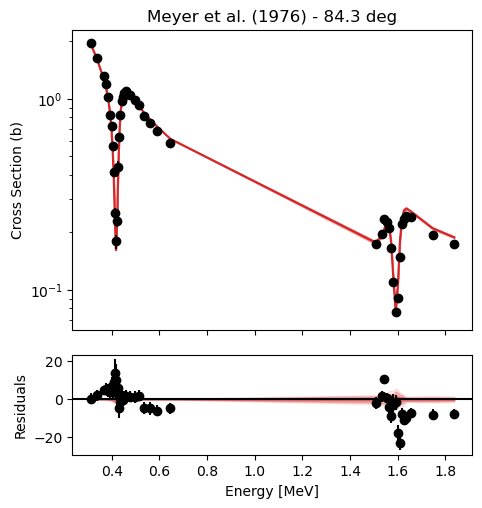

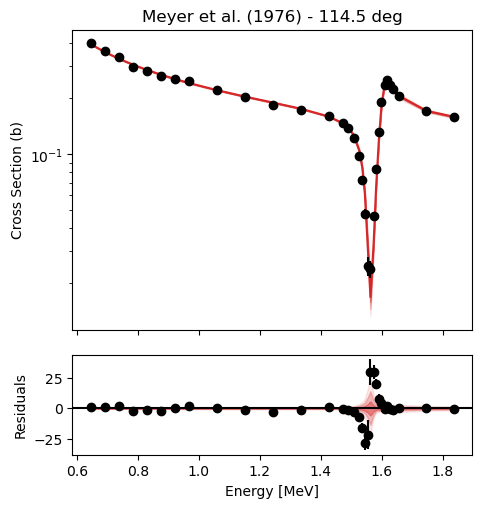

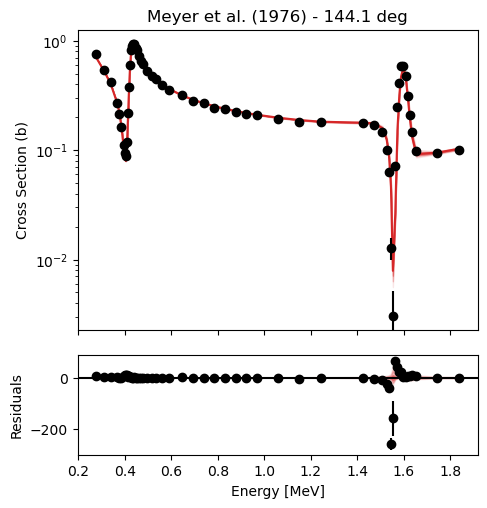

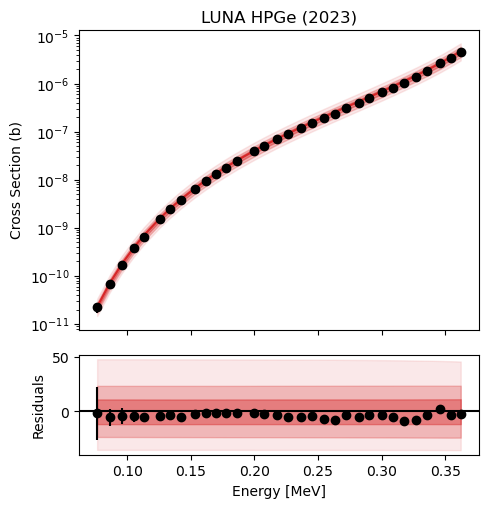

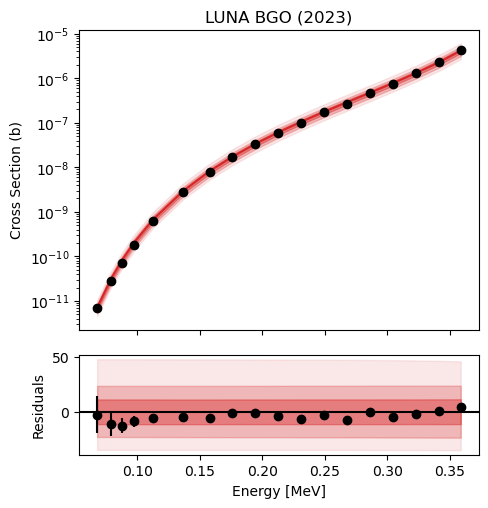

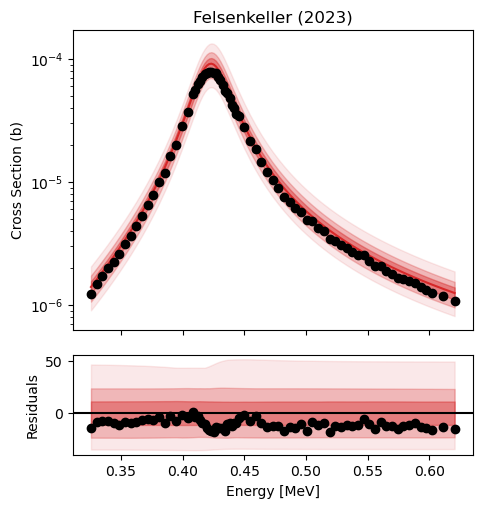

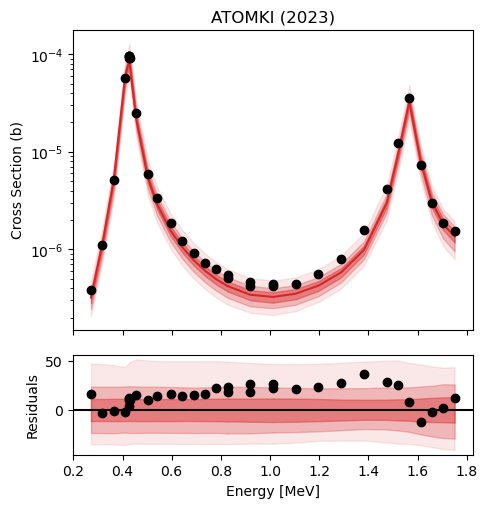

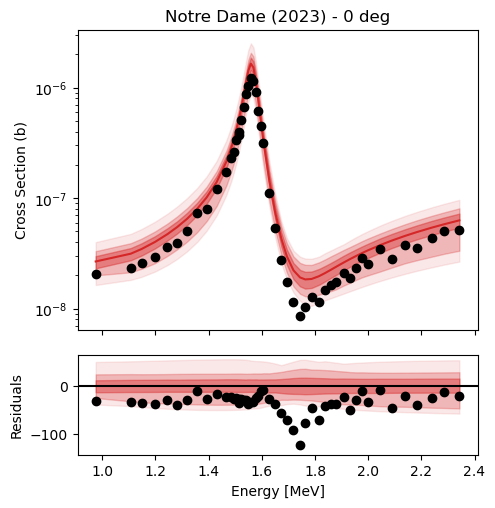

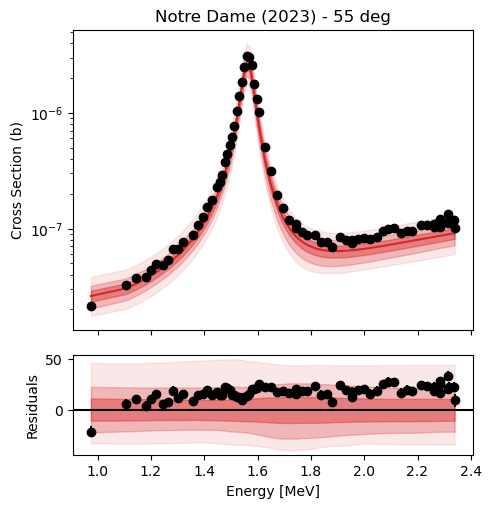

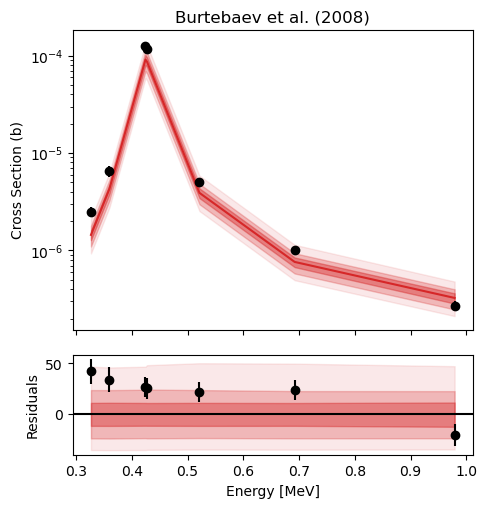

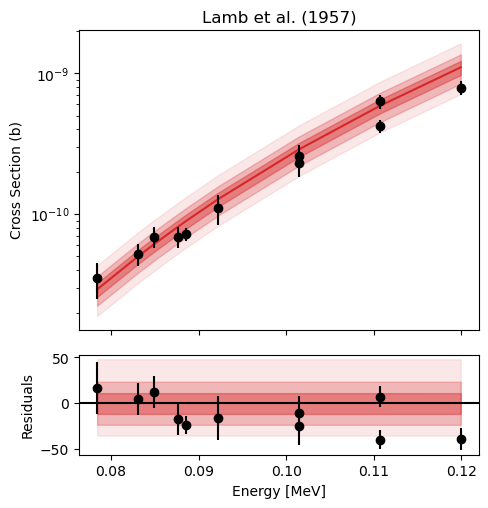

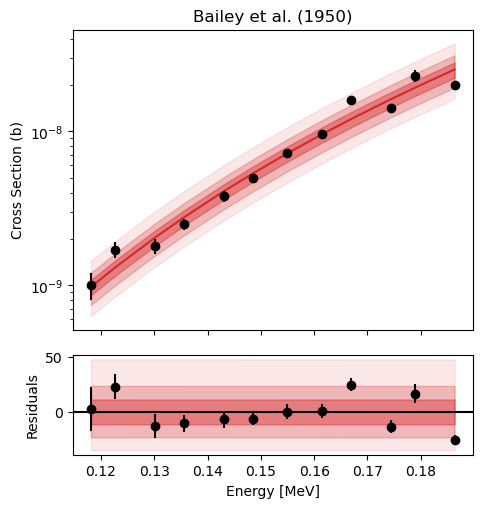

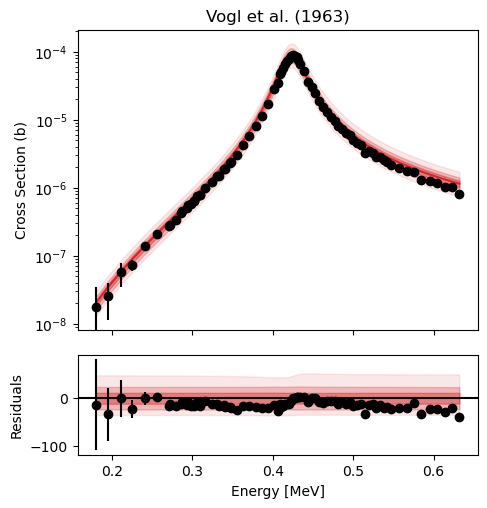

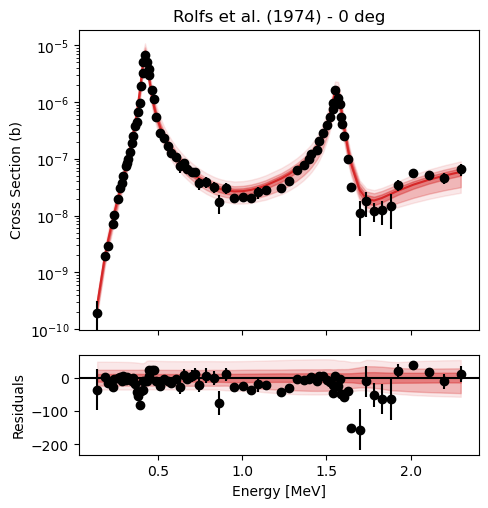

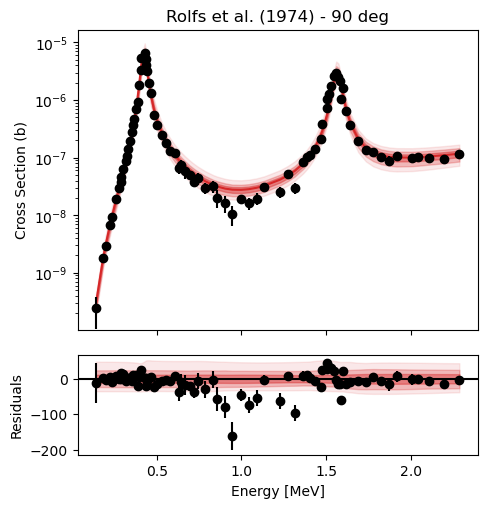

In [4]:
for j, (segment, values) in enumerate(results.items()):
    mean = np.zeros( len( values[0] ) )
    sigma_1up, sigma_1low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    sigma_2up, sigma_2low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    sigma_3up, sigma_3low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    for i in range( len( values[0] ) ):
        mean[i] = np.mean( [ v[i] for v in values ] )
        sigma_1up[i] = np.percentile( [ v[i] for v in values ], 84 ) - mean[i]
        sigma_1low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 16 )
        sigma_2up[i] = np.percentile( [ v[i] for v in values ], 97.5 ) - mean[i]
        sigma_2low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 2.5 )
        sigma_3up[i] = np.percentile( [ v[i] for v in values ], 99.7 ) - mean[i]
        sigma_3low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 0.3 )

    fig1 = plt.figure( figsize=(5,5) )
    ax1 = fig1.add_axes((.1,.35,.8,.6))
    ax1.set_ylabel( "Cross Section (b)" )
    ax1.set_yscale( 'log' )
    ax1.set_xticklabels([])
    ax1.set_title( labels[j] )

    ax1.plot( azr.energies[j], mean, label="Mean", color="tab:red" )
    ax1.errorbar( azr.energies[j], azr.cross[j], yerr=azr.cross_err[j], fmt="o", label=labels[j], color="black" )

    ax1.fill_between( azr.energies[j], mean-sigma_1low, mean+sigma_1up, alpha=0.40, label="1$\sigma$", color="tab:red" )
    ax1.fill_between( azr.energies[j], mean-sigma_2low, mean+sigma_2up, alpha=0.25, label="2$\sigma$", color="tab:red" )
    ax1.fill_between( azr.energies[j], mean-sigma_3low, mean+sigma_3up, alpha=0.10, label="3$\sigma$", color="tab:red" )

    percent = 100 * ( azr.cross[j] - mean ) / azr.cross[j]
    percent_err = 100 * ( azr.cross_err[j] / azr.cross[j] )
    max_percent = max( abs( percent + percent_err ) )

    ax2 = fig1.add_axes((.1,.1,.8,.2))
    ax2.errorbar( azr.energies[j], percent, yerr=percent_err, fmt="o", color="black" )
    ax2.fill_between( azr.energies[j], -100 * sigma_1low / mean, 100 * sigma_1up / mean, color="tab:red", alpha=0.40, label='1 sigma' )
    ax2.fill_between( azr.energies[j], -100 * sigma_2low / mean, 100 * sigma_2up / mean, color="tab:red", alpha=0.25, label='2 sigma' )
    ax2.fill_between( azr.energies[j], -100 * sigma_3low / mean, 100 * sigma_3up / mean, color="tab:red", alpha=0.10, label='3 sigma' )
    ax2.axhline( 0, color="black" )
    
    ax2.set_xlabel( "Energy [MeV]" )
    ax2.set_ylabel( "Residuals" )

    plt.savefig( "results/initial/figures/{}.pdf".format( segment ) )
    plt.show( )

    np.savetxt( "results/initial/data/{}.txt".format( segment ), np.array( [ azr.energies[j], mean, sigma_1up, sigma_1low, sigma_2up, sigma_2low, sigma_3up, sigma_3low ] ).T )